# NTSB Feature Selection

This notebook examines the rates of missingness for each value in the master NTSB dataset, as well as population for dummy variables, allowing us to pare down features which may not be likely to be useful/predictive.

### Note: 
This notebook employs the **'missingno'** package, which can be installed with a "pip install missingno" command in your Terminal.
***


In [17]:
import pandas as pd
import missingno as mno

In [3]:
data = pd.read_csv("../data/ntsb/cleaned/master.csv")

/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_34265/3365207691.py:1: DtypeWarning: Columns (1,39,40,41,42,43,44,45,48,49,50,51,54,55,62) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/ntsb/cleaned/master.csv")


In [14]:
missing = pd.DataFrame(data.isna().sum())
missing_pct = missing / len(data)

<Axes: >

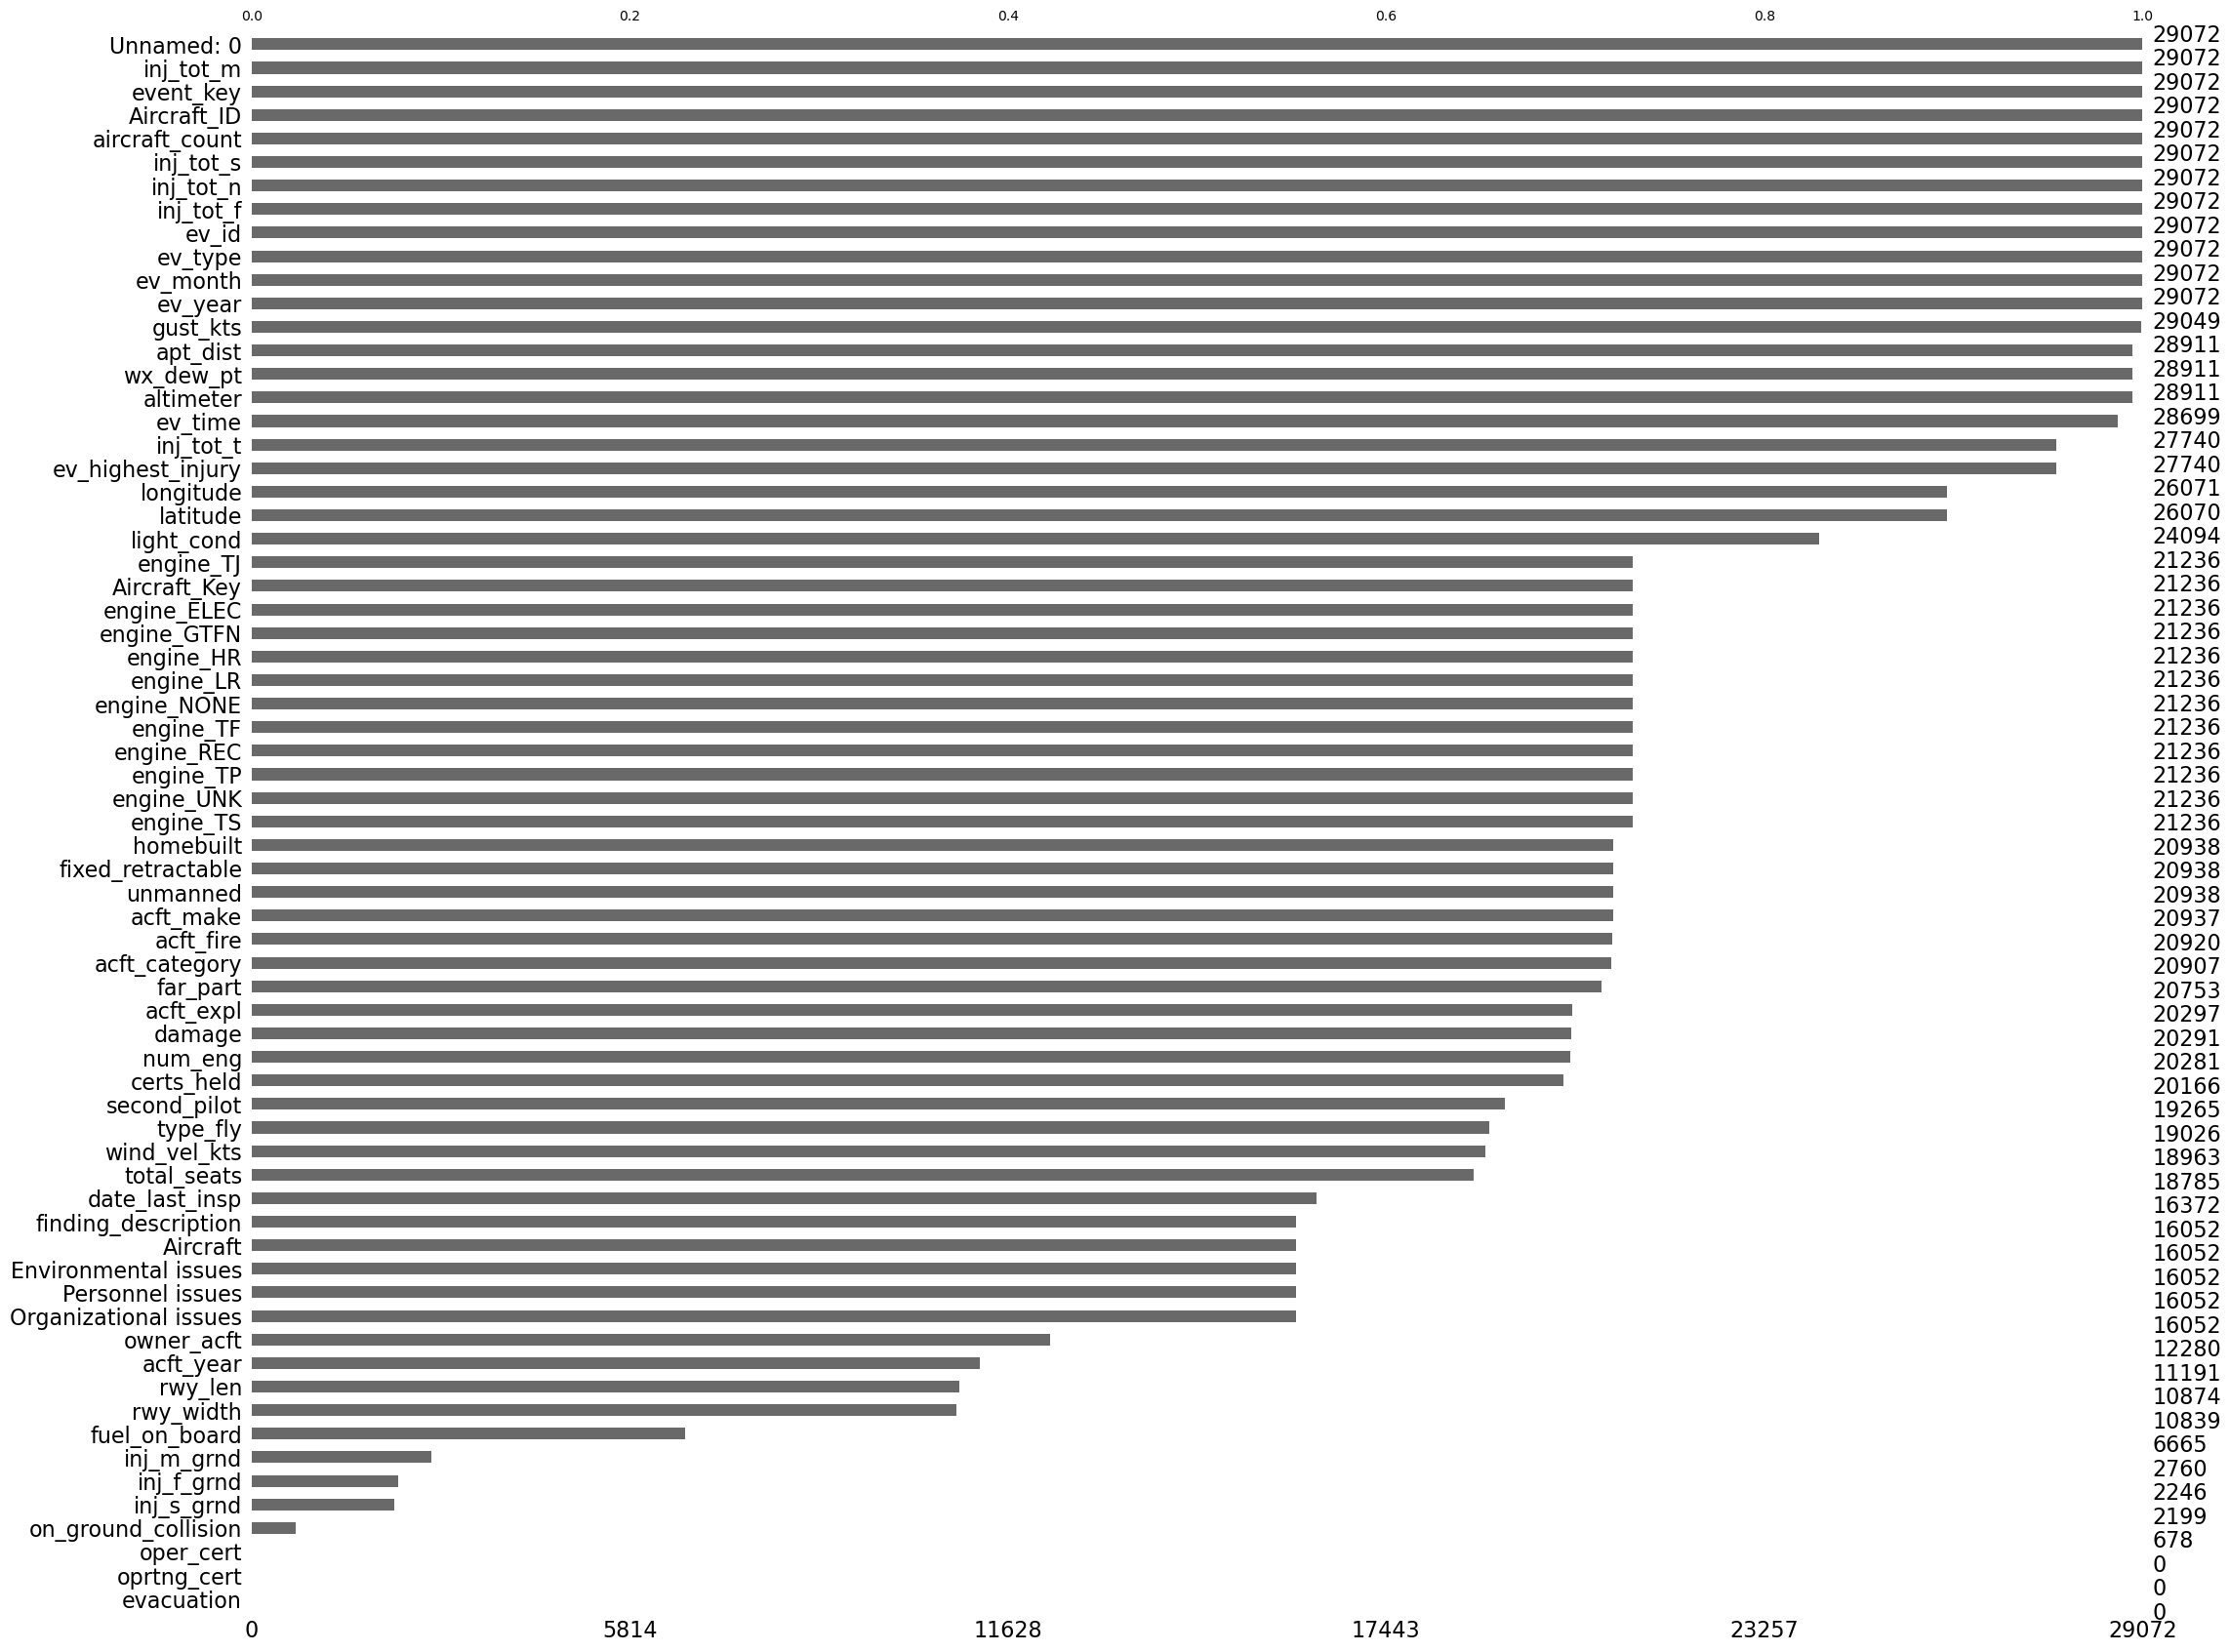

In [21]:
mno.bar(data,sort='ascending')